In [ ]:
pip install spotipy

# Playlist Analysis

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

id = '627414d9842a40a9941c69152d1ef5d4'
secret = '9b1249549b214a9e9bd26f45cda8f44a'

auth_manager = SpotifyClientCredentials(client_id=id, client_secret=secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [ ]:
def get_playlist_tracks(username, playlist_id):
  results = sp.user_playlist_tracks(username, playlist_id)
  tracks = results['items']
  while results['next']:
    results = sp.next(results)
    tracks.extend(results['items'])
  return tracks

tracks = get_playlist_tracks("timo1701", "09PpyE5sNUzEduVcpFyjwH")

In [ ]:
def get_tracks_features(tracks):
  features = []

  for i, t in enumerate(tracks):
    id = t["track"]["id"]
    feature = sp.audio_features(id)
    features.extend(feature)

    if i%100  == 0:
      print(i)

  return features

features = get_tracks_features(tracks)

Let's save those information.

In [ ]:
import json

def save_features(name, features):
  with open(name + ".json", 'w', encoding='utf-8') as file:
    json.dump(features, file)

def load_features(name):
  with open(name + ".json", "r") as file:
    features = json.load(file)
  return features

In [ ]:
import matplotlib.pyplot as plt

def feature_hist(ax, name, features, bins):
  feature = [item[name] for item in features]
  ax.hist(feature, bins=bins)
  ax.title.set_text(name)

fig, axs = plt.subplots(4, 2, figsize=(16, 16))

'''
feature_hist(axs[0, 0], "danceability", features, 30, (0.0, 1.0))
feature_hist(axs[0, 1], "energy", features, 30, (0.0, 1.0))

feature_hist(axs[1, 0], "loudness", features, 30, (0.0, 1.0))
feature_hist(axs[1, 1], "speechiness", features, 30, (0.0, 1.0))

feature_hist(axs[2, 0], "acousticness", features, 30)
feature_hist(axs[2, 1], "instrumentalness", features, 30)

feature_hist(axs[3, 0], "liveness", features, 30)
feature_hist(axs[3, 1], "valence", features, 30)
'''

So what does that learn us? Not much really, we need to compare to others playlists. Let's take those made by spotify.

In [ ]:
#classical enssentials
classic_tracks = get_playlist_tracks("timo1701", "37i9dQZF1DWWEJlAGA9gs0")
classic_features = get_tracks_features(classic_tracks)

0
100


In [ ]:
#rock classics
rock_tracks = get_playlist_tracks("timo1701", "37i9dQZF1DWXRqgorJj26U")
rock_features = get_tracks_features(rock_tracks)

0
100


In [ ]:
#heavy metal
metal_tracks = get_playlist_tracks("timo1701", "37i9dQZF1DX9qNs32fujYe")
metal_features = get_tracks_features(metal_tracks)

0
100


In [ ]:
#jazz classics
jazz_tracks = get_playlist_tracks("timo1701", "37i9dQZF1DXbITWG1ZJKYt")
jazz_features = get_tracks_features(jazz_tracks)

0
100


TypeError: ignored

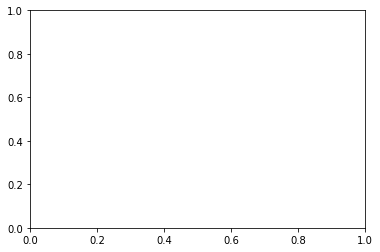

In [ ]:
fig, ax = plt.subplot()

feature_hist(ax, "danceability", classic_features, 10)
feature_hist(ax, "danceability", rock_features, 10)
feature_hist(ax, "danceability", metal_features, 10)
feature_hist(ax, "danceability", jazz_features, 10)

# Data Analysis

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

def getData(path, n):
  data = []
  for i in range(n):
    name = path + "StreamingHistory" + str(i) + ".json"
    with open(name) as f:
      data += json.load(f)
  return data

def getTime(data):
  time = []
  for item in data:
      t = item['endTime']
      t = datetime.strptime(t, '%Y-%m-%d %H:%M')
      time.append(t)
  return time

data = getData("/content/", 5)
time = getTime(data)

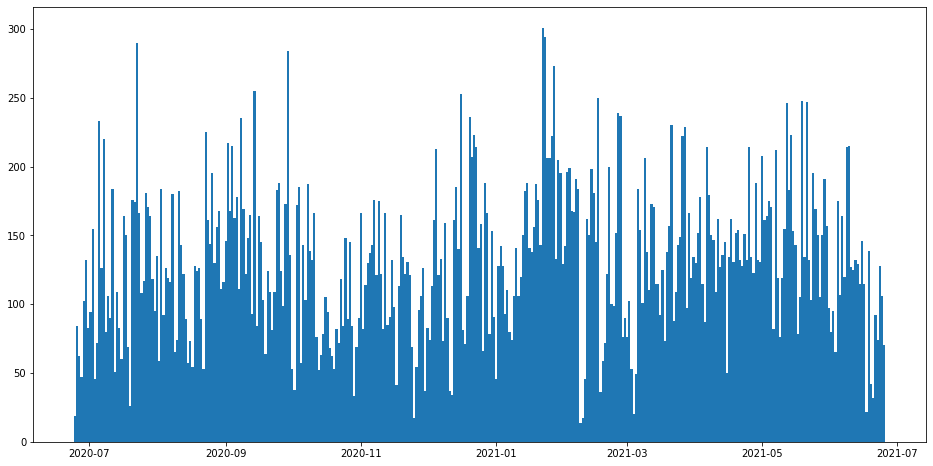

In [ ]:
def plotDailyStreamingHistory(time):
  start = time[0]
  end = time[-1]
  delta = (end - start).days

  # plot it
  fig, ax = plt.subplots(figsize=(16, 8))
  ax.hist(time, bins=delta)
  locator = mdates.AutoDateLocator()
  ax.xaxis.set_major_locator(locator)
  ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
  plt.show()

plotDailyStreamingHistory(time)

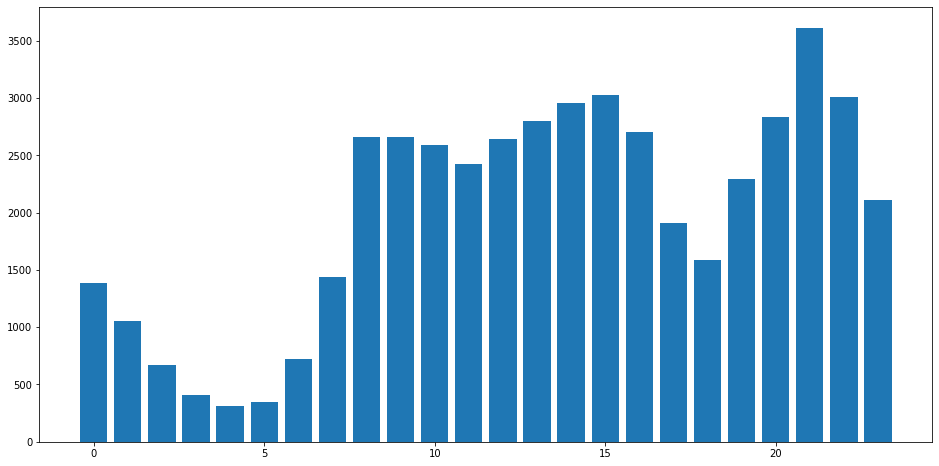

In [ ]:
def plotHourlyStreamingHistory(time):
  hours = [0 for y in range(24)]
  y = [y for y in range(24)]
  
  for t in time:
    hours[t.hour] += 1
  
  fig, ax = plt.subplots(figsize=(16, 8))
  ax.bar(y, hours)
  plt.show()

plotHourlyStreamingHistory(time)

Let's look at my most popular songs and many times I've played them.

In [ ]:
# count = {'count':, 'artistName': , 'trackName': , 'msPlayed':}

def countSongOccurrences(time):
  occurences = []

  while len(time) > 0:
    artistName = time[-1]["artistName"]
    trackName = time[-1]["trackName"]
    msPlayed = 0
    count = 0
    
    for i in reversed(range(len(time))):
      if time[i]["artistName"] == artistName:
        count += 1
        msPlayed += time[i]["msPlayed"]
        time.pop(i)

    minPlayed = int(msPlayed / (1000 * 60))
    occurence = {'count': count, 'artistName': artistName, 'trackName': trackName, "minPlayed": minPlayed}
    occurences.append(occurence)

  return occurences

data = getData("/content/", 4)
occurences = countSongOccurrences(data)

In [ ]:
# count = {'count':, 'artistName': , 'msPlayed':}

def countArtistOccurrences(data):
  occurences = []
  time = copy.copy(data)

  while len(time) > 0:
    artistName = time[-1]["artistName"]
    msPlayed = 0
    count = 0
    
    for i in reversed(range(len(time))):
      if time[i]["artistName"] == artistName:
        count += 1
        msPlayed += time[i]["msPlayed"]
        time.pop(i)

    minPlayed = int(msPlayed / (1000 * 60))
    occurence = {'count': count, 'artistName': artistName, "minPlayed": minPlayed}
    occurences.append(occurence)

  return occurences

data = getData("/content/", 4)

In [ ]:
favorite_song = sorted(song_occurences, key=lambda x: x['count'], reverse=True) 
print("Favorite Songs")
for i in range(10):
  print(favorite_song[i])

Favorite Songs
{'count': 117, 'artistName': 'Imagine Dragons', 'trackName': 'Birds', 'minPlayed': 409}
{'count': 88, 'artistName': 'The Districts', 'trackName': '4th and Roebling', 'minPlayed': 321}
{'count': 86, 'artistName': 'Alan Walker', 'trackName': 'Intro', 'minPlayed': 144}
{'count': 83, 'artistName': 'Machine Gun Kelly', 'trackName': 'forget me too (feat. Halsey)', 'minPlayed': 202}
{'count': 82, 'artistName': 'The Districts', 'trackName': '6 AM', 'minPlayed': 395}
{'count': 75, 'artistName': 'Videoclub', 'trackName': 'Enfance 80', 'minPlayed': 228}
{'count': 74, 'artistName': 'grandson', 'trackName': 'Identity', 'minPlayed': 210}
{'count': 71, 'artistName': 'Machine Gun Kelly', 'trackName': "my ex's best friend (with blackbear)", 'minPlayed': 141}
{'count': 70, 'artistName': 'Machine Gun Kelly', 'trackName': "I Think I'm OKAY (with YUNGBLUD & Travis Barker)", 'minPlayed': 174}
{'count': 69, 'artistName': 'grandson', 'trackName': 'Blood // Water', 'minPlayed': 157}


In [ ]:
favorite_artist = sorted(artist_occurences, key=lambda x: x['count'], reverse=True) 
print("Favorite Artist")
for i in range(10):
  print(favorite_artist[i])

Favorite Artist
{'count': 1393, 'artistName': 'The Districts', 'minPlayed': 5255}
{'count': 1368, 'artistName': 'Machine Gun Kelly', 'minPlayed': 3013}
{'count': 801, 'artistName': 'grandson', 'minPlayed': 2234}
{'count': 696, 'artistName': 'Supertramp', 'minPlayed': 2999}
{'count': 671, 'artistName': 'Robin Schulz', 'minPlayed': 2104}
{'count': 564, 'artistName': 'EDEN', 'minPlayed': 2029}
{'count': 521, 'artistName': 'NF', 'minPlayed': 1726}
{'count': 515, 'artistName': 'French 79', 'minPlayed': 1908}
{'count': 508, 'artistName': 'Oh Wonder', 'minPlayed': 1625}
{'count': 490, 'artistName': 'Imagine Dragons', 'minPlayed': 1226}


In [ ]:
data = getData("/content/", 5)

print("Number of streams: " + str(len(data)))
print("Number of different songs: " + str(len(favorite_song)))
print("Number of different artists: " + str(len(favorite_artist)))

Number of streams: 48147
Number of different songs: 9108
Number of different artists: 3268


Now split our song history in different genres. We will for each artist in "favorite artist" find the genre(s) with the spotipy api and then parse over the streaming history to classify the stream into the different genres.

In [ ]:
for i in range(len(favorite_artist)):
  #find artist
  artist = favorite_artist[i]
  name = artist["artistName"]
  results = sp.search(q=name, type='artist')
  
  try:  
    results = results["artists"]["items"][0]

    #extract information
    genres = results["genres"]
    popularity = results["popularity"]
  
    #add informations
    artist["genres"] = genres
    artist["popularity"] = popularity
  except:
    print("not found: " + name)

So now we will loop through the streaming history and add each stream to the corresponding genre.

In [ ]:
#to avoid any problems we add a boiler plate artist
artist = {'count': 0, 'artistName': '', 'minPlayed': 0, 'genres': [], 'popularity': 0}
favorite_artist.append(artist)

{'count': 0, 'artistName': '', 'minPlayed': 0, 'genres': [], 'popularity': 0}


In [ ]:
def getArtistIndex(favorite_artist, artistName):
  for i in range(len(favorite_artist)):
    if favorite_artist[i]["artistName"] == artistName:
      #return index
      return i

  #return our boilerplate artist
  return -1

genres = []

for song in data:
  #we get the artist index
  index = getArtistIndex(favorite_artist, song["artistName"])
  try:
    #we get the artist genres
    artist_genres = favorite_artist[index]["genres"]

    #we add to each song the artist genres
    song["genres"] = artist_genres
    
    #we add the genre to the list of genres
    genres.append(genre)
  except:
    pass

In [ ]:
genres = sorted(genres)
listed_genres = [] #let's filter the genres

while len(genres) > 0:
  c = 0
  name = genres[0]

  #remove from list
  while len(genres) > 0 and genres[0] == name:
    genres.pop(0)
    c += 1
  
  genre = {"name": name, "count": c}
  listed_genres.append(genre)

TypeError: ignored

In [ ]:
print(listed_genres[:5])

[{'name': 'nz electronic', 'count': 48131}]


Now subdivide our listen to each genre